In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Bitcoin OTC Network Analysis # 

This is who-trusts-whom network of people who trade using Bitcoin on a platform called Bitcoin OTC. Since Bitcoin users are anonymous, there is a need to maintain a record of users' reputation to prevent transactions with fraudulent and risky users. Members of Bitcoin OTC rate other members in a scale of -10 (total distrust) to +10 (total trust) in steps of 1. This is the first explicit weighted signed directed network available for research.

Each line has one rating, sorted by time, with the following format:

SOURCE, TARGET, RATING, TIME
where
* SOURCE: node id of source, i.e., rater
* TARGET: node id of target, i.e., ratee
* RATING: the source's rating for the target, ranging from -10 to +10 in steps of 1
* TIME: the time of the rating, measured as seconds since Epoch.

**Dataset statistics**
* Nodes	                     5,881
* Edges	                    35,592
* Range of edge weight	-10 to +10
* Percentage of positive edges	89%

### Import Packages ###


In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline

### Analysis ###
The edges are loaded from the data folder and saved in a dataframe. Each edge is a new row and for each edge there is a start_node and an end_node column

In [5]:
# dataset link
url = "https://snap.stanford.edu/data/soc-sign-bitcoinotc.csv.gz"

# Load the gzipped CSV with correct parameters
df = pd.read_csv(
    url,
    sep=",",
    names=["source", "target", "rating", "time"],
    header=None,
    compression="gzip"
)

df

,source,target,rating,time
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09
...,...,...,...,...
35587,4499,1810,1,1.453612e+09
35588,2731,3901,5,1.453679e+09
35589,2731,4897,5,1.453679e+09
35590,13,1128,1,1.453680e+09


### Visualization Graph ###


Here start the visualization of the graph. Since, we don't have any sense of structure of the data , we can start by random_layout. 

In [4]:
G = nx.from_pandas_edgelist(df, source="source", target="target")

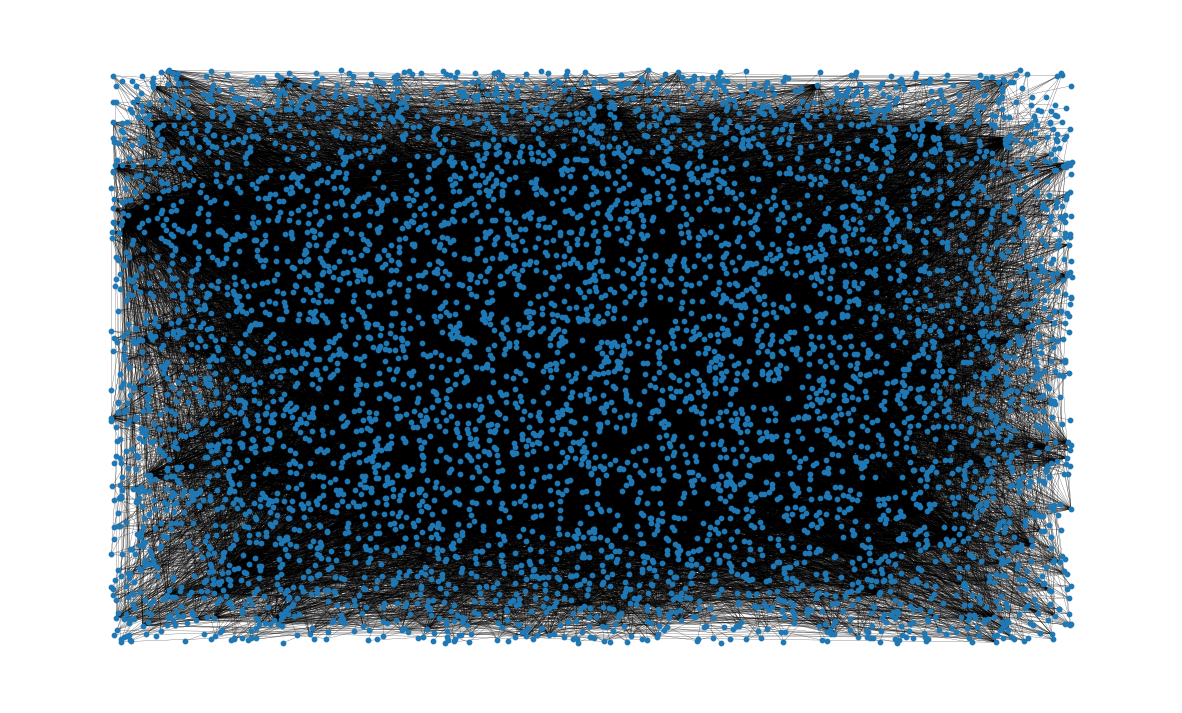

In [5]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

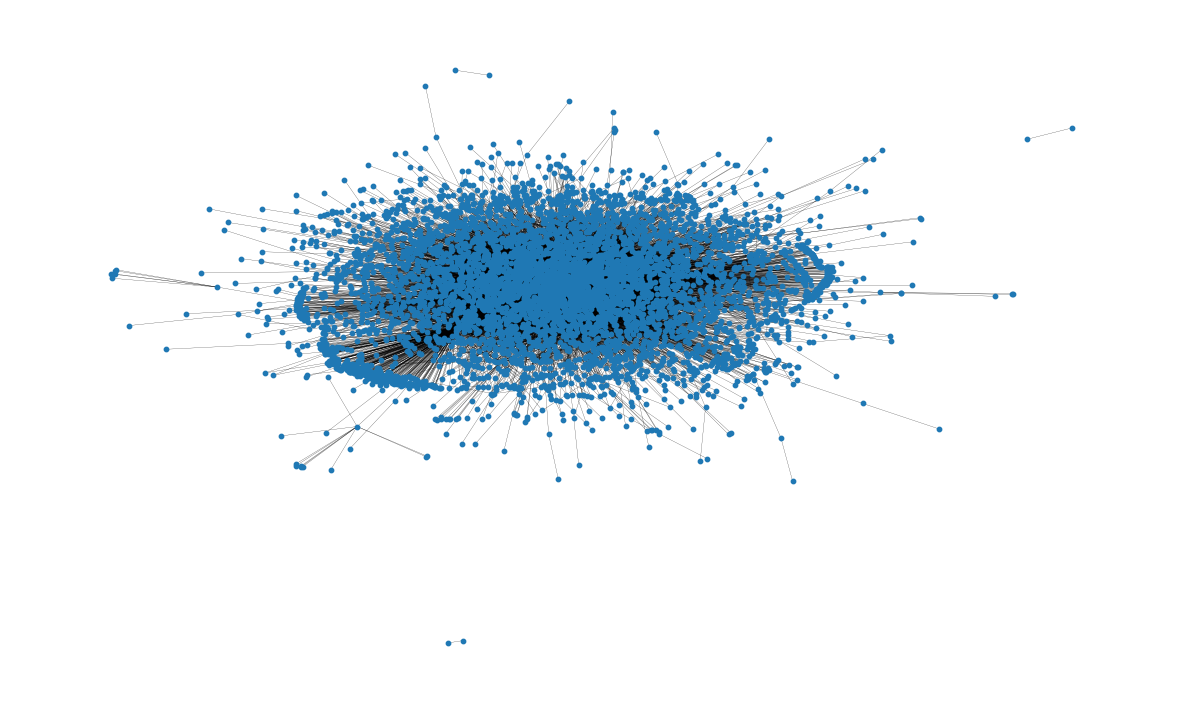

In [6]:
# Generate layout positions for nodes
pos = nx.spring_layout(G, iterations=15, seed=1721)

# Create a figure for plotting
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")

# Define plotting options
plot_options = {
    "node_size": 10,
    "with_labels": False,
    "width": 0.15
}

# Draw the graph
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

plt.show()


In [7]:
G.number_of_edges()


21492

In [8]:
np.mean([d for _, d in G.degree()])


7.30896106104404

In [9]:
# Use the largest connected component
largest_cc = max(nx.connected_components(G), key=len)
G_sub = G.subgraph(largest_cc).copy()

In [11]:
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))


In [13]:
shortest_path_lengths[1][95]

2

In [17]:
# Get connected components
components = list(nx.connected_components(G))

# Iterate through each component and calculate eccentricity
eccentricities = {}
for component in components:
    subgraph = G.subgraph(component)
    sub_eccentricities = nx.eccentricity(subgraph)
    eccentricities.update(sub_eccentricities)

# Now you can get the diameter from the eccentricities
diameter = max(eccentricities.values())
print(diameter)

9


In [18]:
# Compute the average shortest path length for each node
average_path_lengths = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
]
# The average over all nodes
np.mean(average_path_lengths)

3.567347368192557

Text(0, 0.5, 'Frequency (%)')

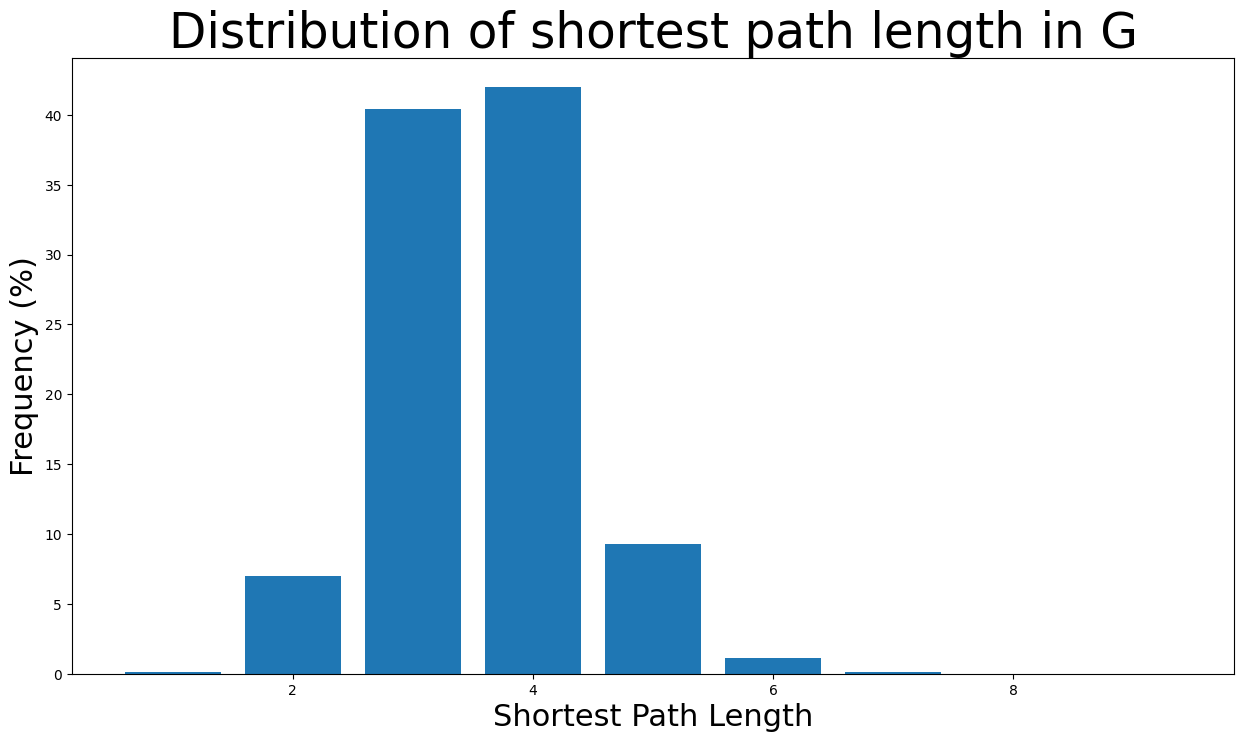

In [19]:
path_lengths = np.zeros(diameter + 1, dtype=int)

# Extract the frequency of shortest path lengths between two nodes
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

# Express frequency distribution as a percentage (ignoring path lengths of 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

# Plot the frequency distribution (ignoring path lengths of 0) as a percentage
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title(
    "Distribution of shortest path length in G", fontdict={"size": 35}, loc="center"
)
ax.set_xlabel("Shortest Path Length", fontdict={"size": 22})
ax.set_ylabel("Frequency (%)", fontdict={"size": 22})

In [20]:
nx.density(G)

0.001243020588612932

In [21]:
nx.number_connected_components(G)


4

## Degree Centrality ##

In [22]:
degree_centrality = nx.centrality.degree_centrality(
    G
)  # save results in a variable to use again
(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

[(35, 0.13520408163265304),
 (1810, 0.07465986394557822),
 (2642, 0.07448979591836734),
 (2125, 0.07414965986394557),
 (2028, 0.055442176870748296),
 (905, 0.05442176870748299),
 (4172, 0.049829931972789114),
 (1, 0.044897959183673466),
 (7, 0.04064625850340136),
 (3129, 0.036904761904761905)]

In [23]:
(sorted(G.degree, key=lambda item: item[1], reverse=True))[:10]


[(35, 795),
 (1810, 439),
 (2642, 438),
 (2125, 436),
 (2028, 326),
 (905, 320),
 (4172, 293),
 (1, 264),
 (7, 239),
 (3129, 217)]

Text(0, 0.5, 'Counts')

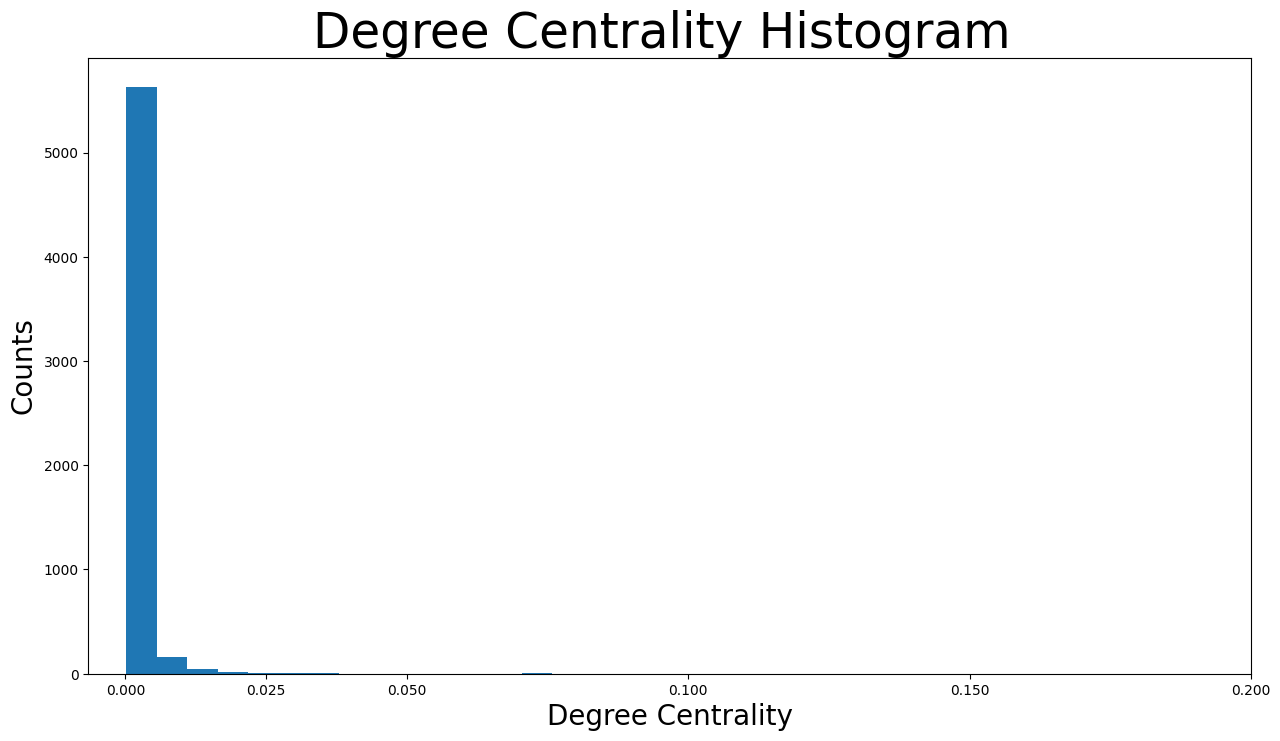

In [25]:
plt.figure(figsize=(15, 8))
plt.hist(degree_centrality.values(), bins=25)
plt.xticks(ticks=[0, 0.025, 0.05, 0.1, 0.15, 0.2])  # set the x axis ticks
plt.title("Degree Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

(-0.6647235071659088,
 0.7534711277484893,
 -1.169732038974762,
 0.7862276482582093)

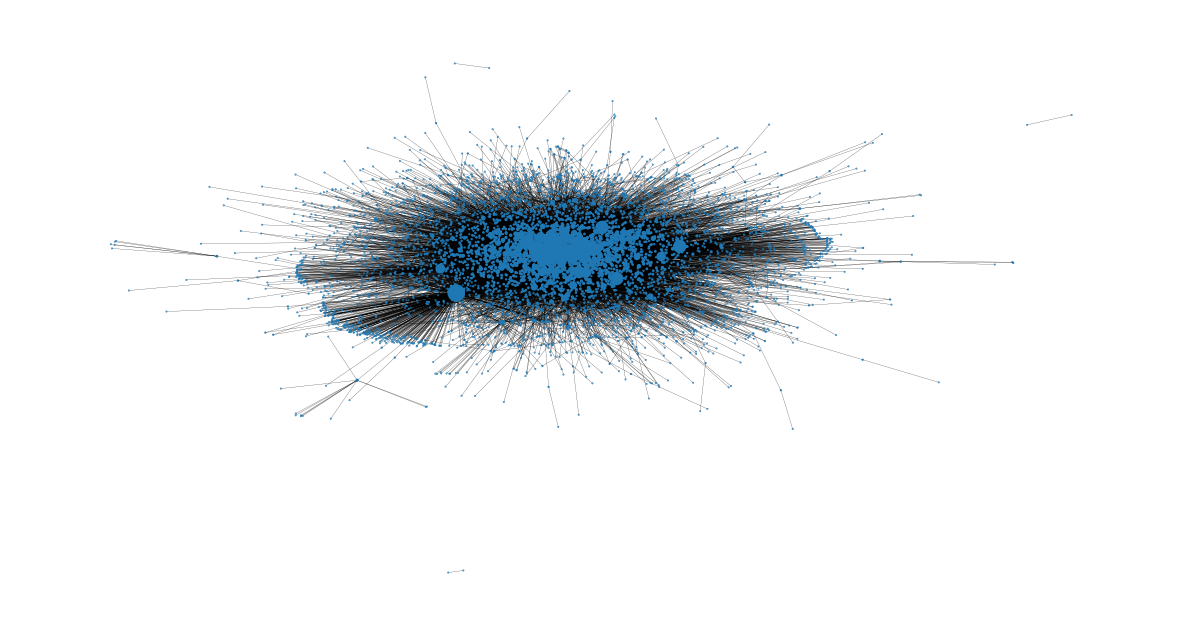

In [26]:
node_size = [
    v * 1000 for v in degree_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

## Betweenness Centrality ##

In [27]:
betweenness_centrality = nx.centrality.betweenness_centrality(
    G
)  # save results in a variable to use again
(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

[(35, 0.19314290581747087),
 (2125, 0.07773870646631356),
 (2642, 0.06472392400748599),
 (1810, 0.06162200592181885),
 (1, 0.052810444130605795),
 (905, 0.05258480998344456),
 (3129, 0.05196405722817834),
 (4172, 0.04966124418313705),
 (2028, 0.0444701275121264),
 (7, 0.039281028854122185)]

Text(0, 0.5, 'Counts')

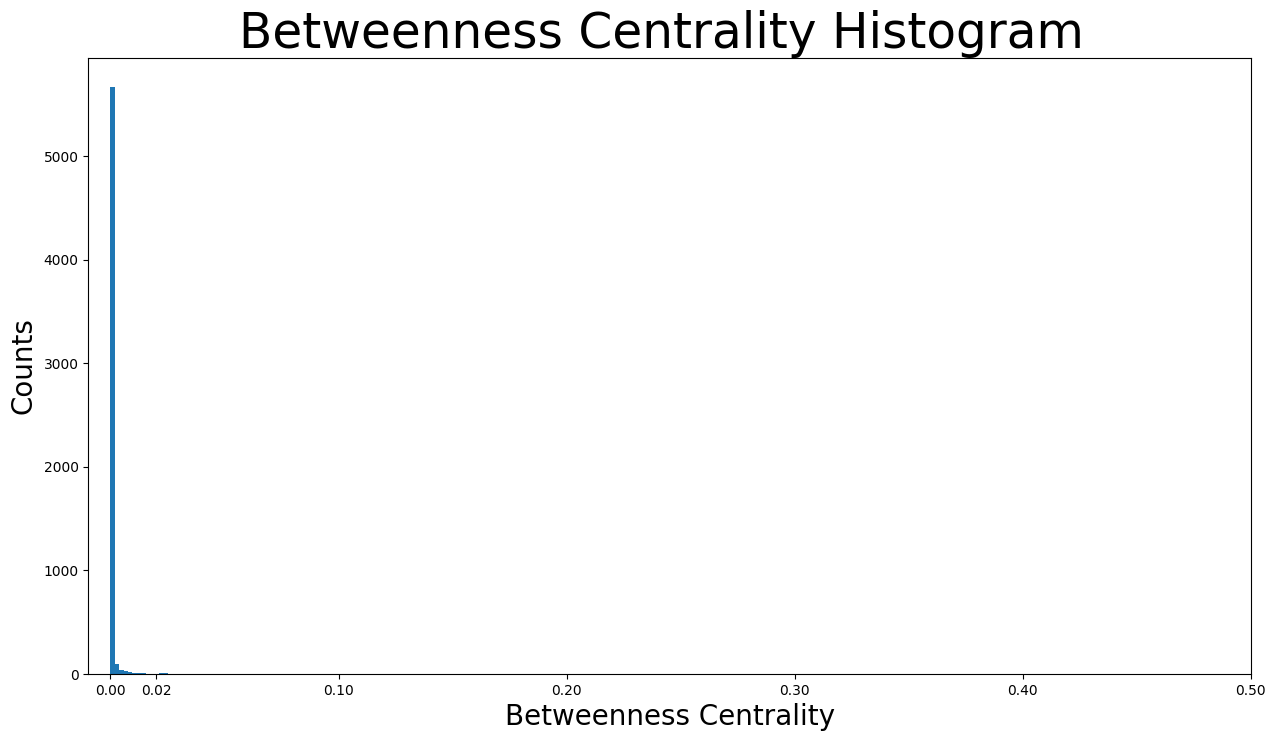

In [28]:
plt.figure(figsize=(15, 8))
plt.hist(betweenness_centrality.values(), bins=100)
plt.xticks(ticks=[0, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5])  # set the x axis ticks
plt.title("Betweenness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Betweenness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

(-0.6647235071659088,
 0.7534711277484893,
 -1.169732038974762,
 0.7862276482582093)

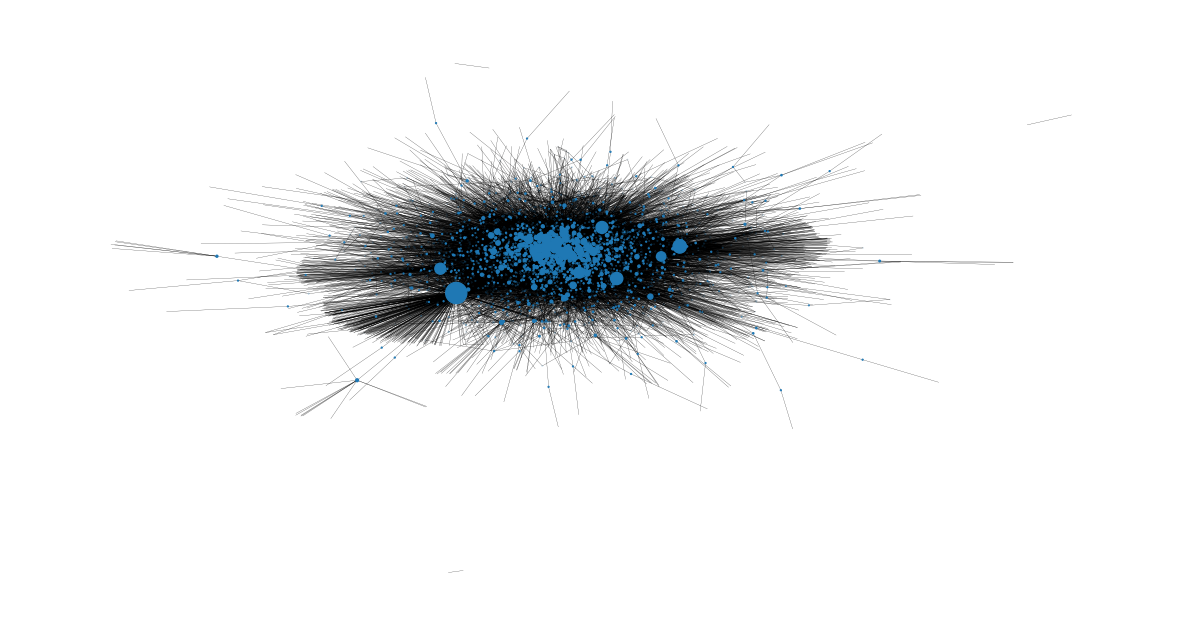

In [29]:
node_size = [
    v * 1200 for v in betweenness_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

## Closeness Centrality ##

In [30]:
closeness_centrality = nx.centrality.closeness_centrality(
    G
)  # save results in a variable to use again
(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

[(905, 0.4360236381668138),
 (1, 0.4330312244446151),
 (35, 0.4274791376447133),
 (2388, 0.41896373857268165),
 (1810, 0.41095357675250227),
 (2642, 0.4104648938478581),
 (13, 0.4100919786462352),
 (2296, 0.40764196751990134),
 (2028, 0.40730243093280905),
 (2125, 0.4069634594943463)]

In [31]:
1 / closeness_centrality[905]


2.2934536398171614

Text(0, 0.5, 'Counts')

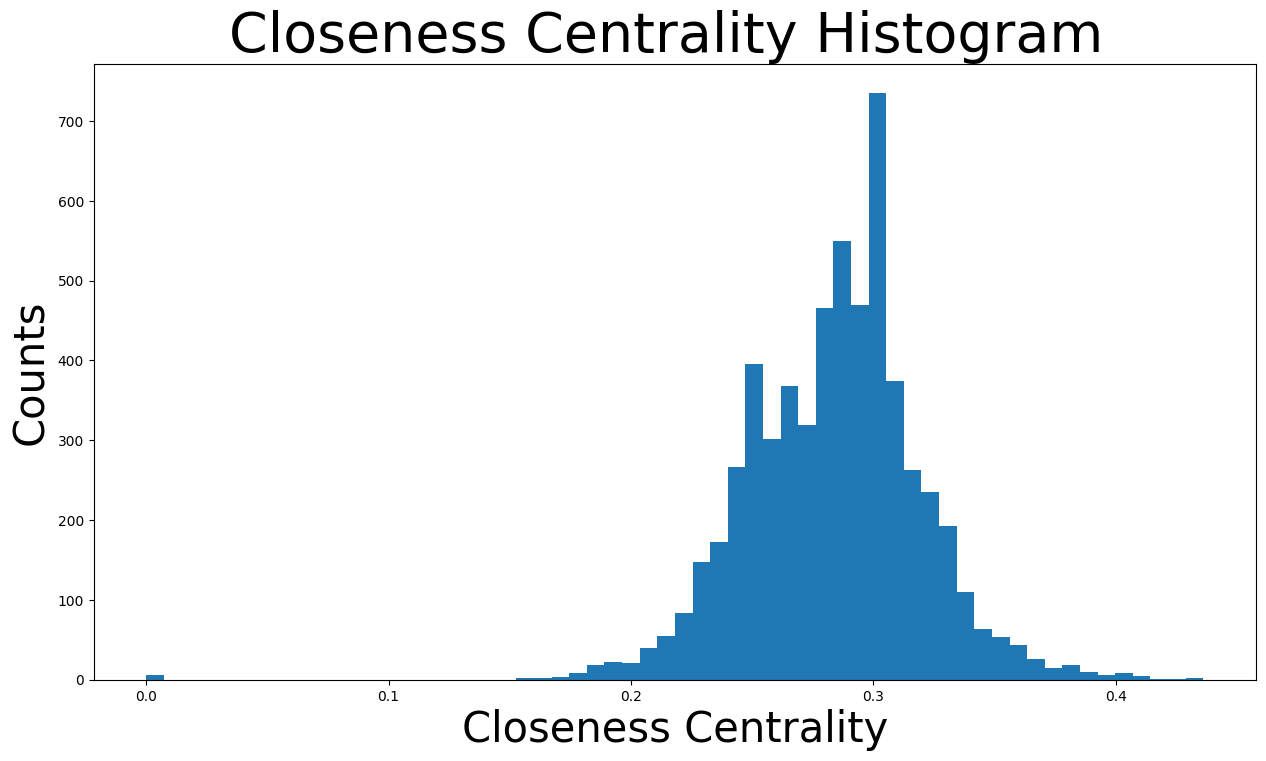

In [32]:
plt.figure(figsize=(15, 8))
plt.hist(closeness_centrality.values(), bins=60)
plt.title("Closeness Centrality Histogram ", fontdict={"size": 40}, loc="center")
plt.xlabel("Closeness Centrality", fontdict={"size":30})
plt.ylabel("Counts", fontdict={"size": 30})

(-0.6647235071659088,
 0.7534711277484893,
 -1.169732038974762,
 0.7862276482582093)

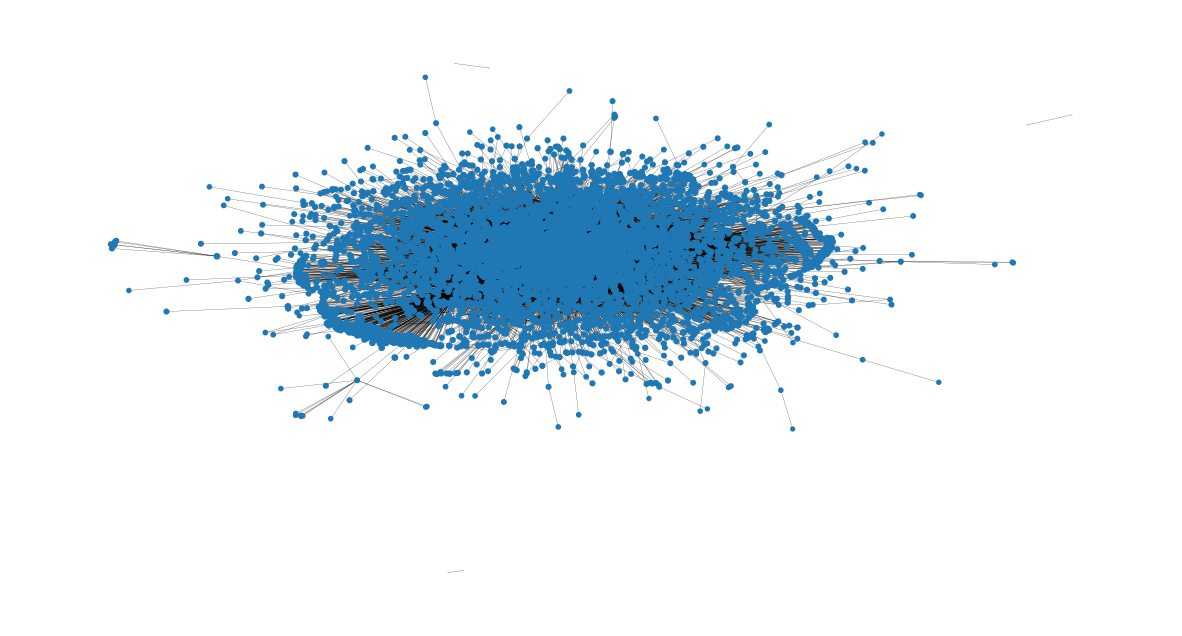

In [33]:
node_size = [
    v * 50 for v in closeness_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

## Eigenvector Centrality ##

In [34]:
eigenvector_centrality = nx.centrality.eigenvector_centrality(
    G
)  # save results in a variable to use again
(sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

[(905, 0.18865262489955736),
 (1810, 0.18264066474141957),
 (2642, 0.17507672501599664),
 (2028, 0.15483942213094168),
 (2125, 0.14870445273176902),
 (35, 0.14606587757009276),
 (1, 0.14085039422756973),
 (1334, 0.13536451390629617),
 (4172, 0.13533468227011672),
 (2388, 0.1337868786214861)]

In [38]:
high_eigenvector_centralities = (
    sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True)
)[
    1:10
]  # 2nd to 10th nodes with heighest eigenvector centralities
high_eigenvector_nodes = [
    tuple[0] for tuple in high_eigenvector_centralities
]  # set list as [1810, 2642,2028, 2125, 35, 1, 1334, 4172, 2288]
neighbors_905 = [n for n in G.neighbors(905)]  # list with all nodes connected to 1912
all(
    item in neighbors_905 for item in high_eigenvector_nodes)

True

Text(0, 0.5, 'Counts')

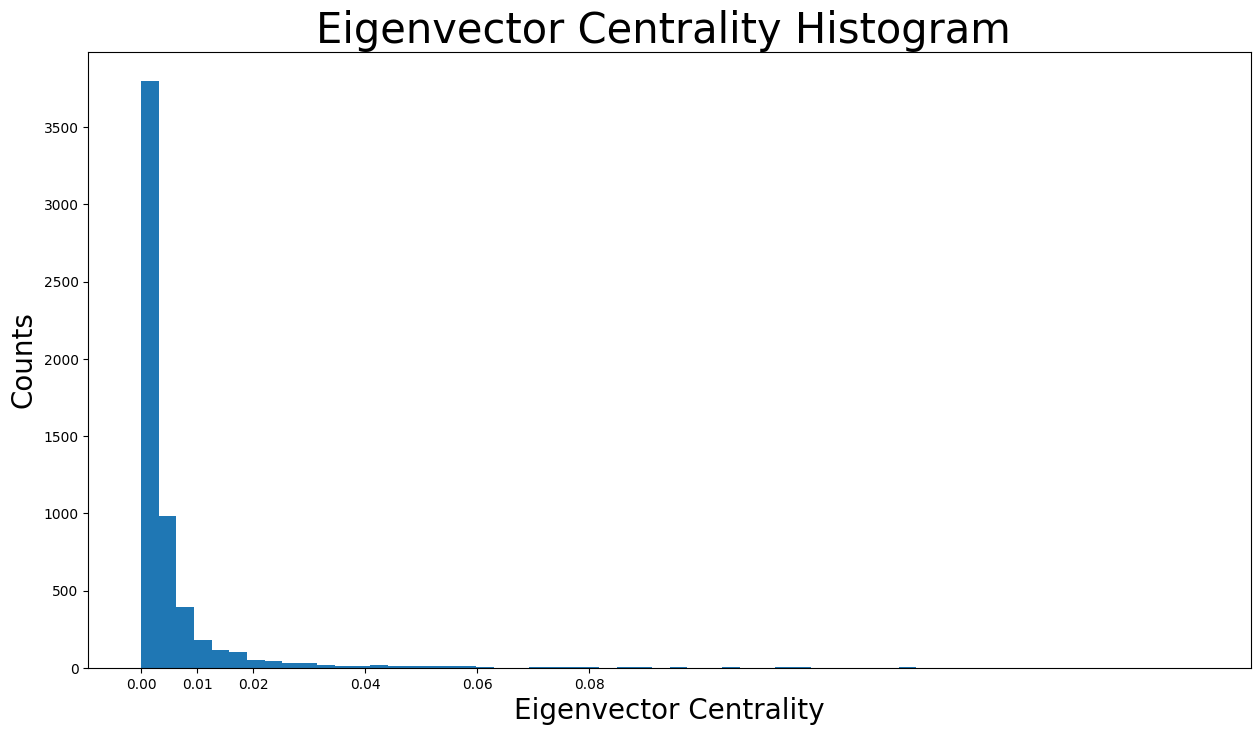

In [39]:
plt.figure(figsize=(15, 8))
plt.hist(eigenvector_centrality.values(), bins=60)
plt.xticks(ticks=[0, 0.01, 0.02, 0.04, 0.06, 0.08])  # set the x axis ticks
plt.title("Eigenvector Centrality Histogram ", fontdict={"size": 30}, loc="center")
plt.xlabel("Eigenvector Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

(-0.6647235071659088,
 0.7534711277484893,
 -1.169732038974762,
 0.7862276482582093)

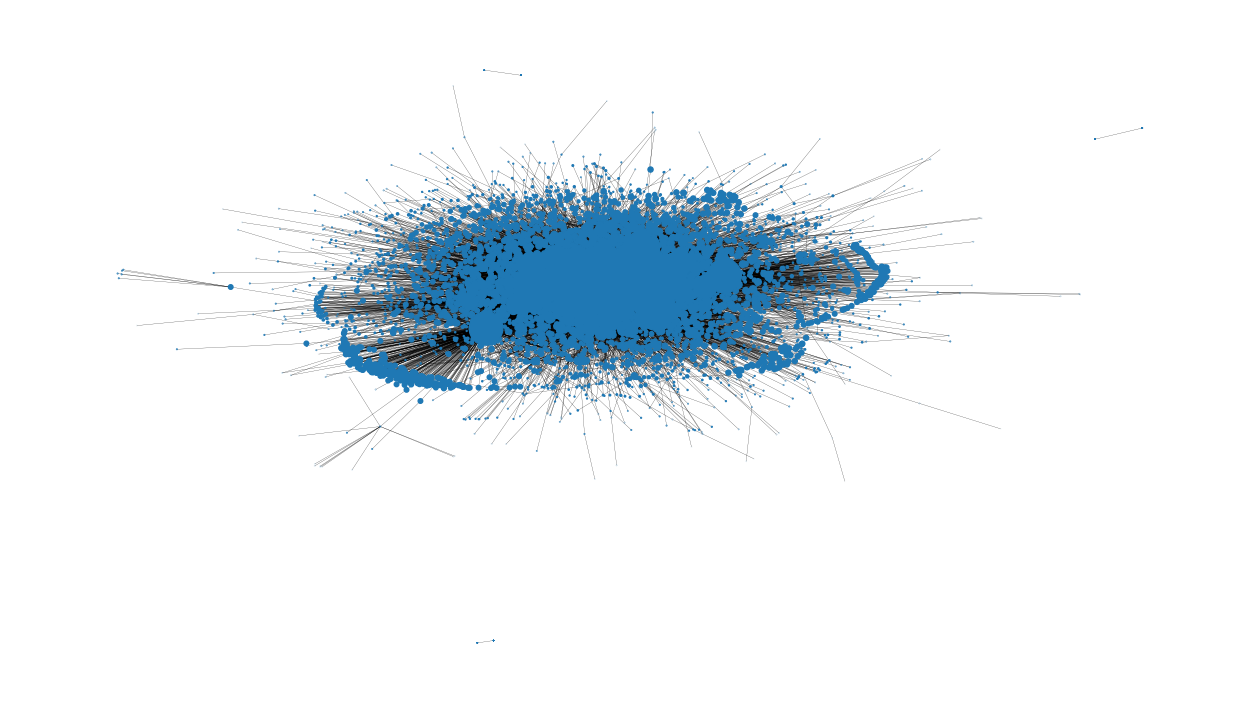

In [40]:
node_size = [
    v * 4000 for v in eigenvector_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(16, 9))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

In [41]:
nx.average_clustering(G)


0.17750449405289517

Text(0, 0.5, 'Counts')

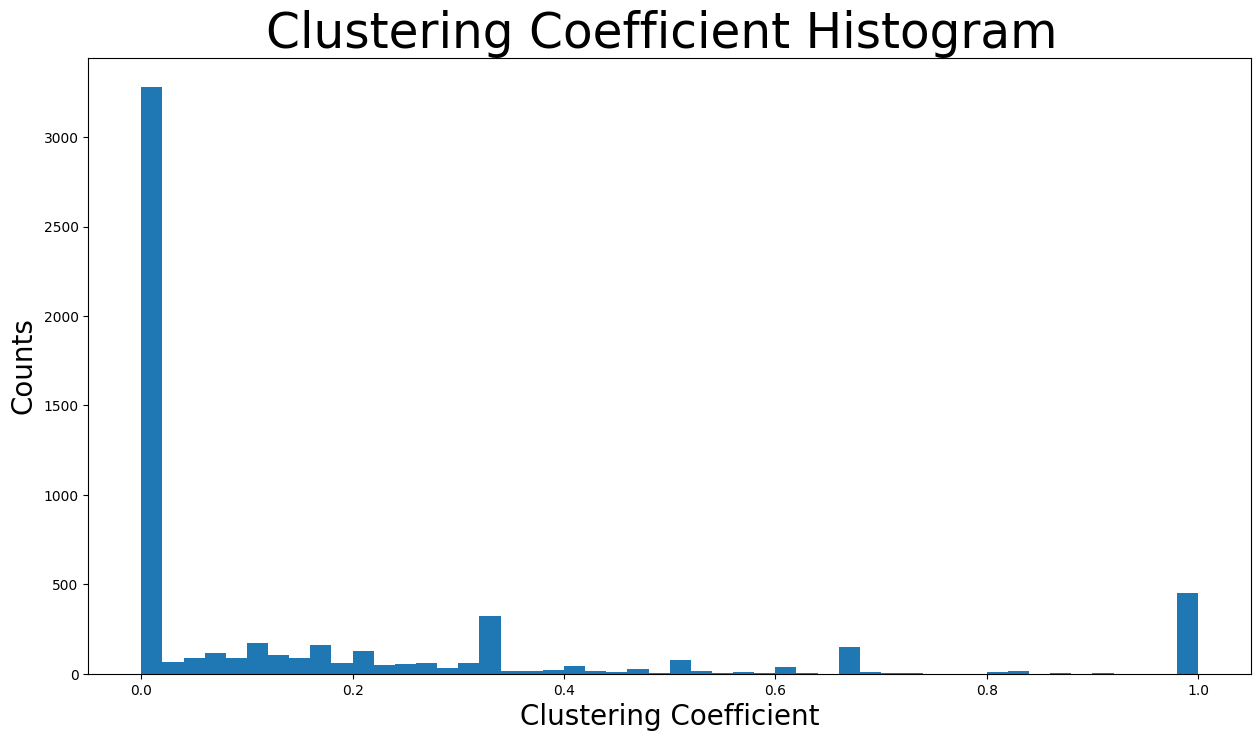

In [42]:
plt.figure(figsize=(15, 8))
plt.hist(nx.clustering(G).values(), bins=50)
plt.title("Clustering Coefficient Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Clustering Coefficient", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

In [43]:
triangles_per_node = list(nx.triangles(G).values())
sum(
    triangles_per_node
) / 3  # divide by 3 because each triangle is counted once for each node

33493.0

In [44]:
np.mean(triangles_per_node)

17.085359632715523

In [46]:
nx.has_bridges(G)


True

In [47]:
bridges = list(nx.bridges(G))
len(bridges)

2290

In [48]:
local_bridges = list(nx.local_bridges(G, with_span=False))
len(local_bridges)


6405

(-0.6647235071659088,
 0.7534711277484893,
 -1.169732038974762,
 0.7862276482582093)

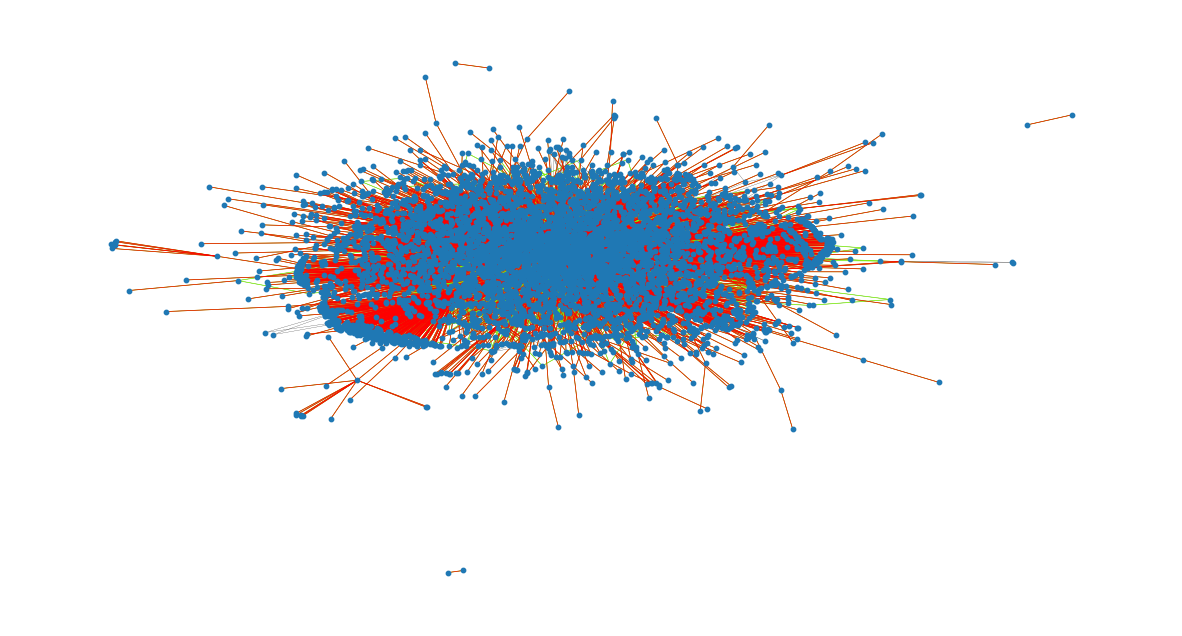

In [49]:
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=10, with_labels=False, width=0.15)
nx.draw_networkx_edges(
    G, pos, edgelist=local_bridges, width=0.5, edge_color="lawngreen"
)  # green color for local bridges
nx.draw_networkx_edges(
    G, pos, edgelist=bridges, width=0.5, edge_color="r"
)  # red color for bridges
plt.axis("off")

In [50]:
nx.degree_assortativity_coefficient(G)


-0.16483359451314514

In [51]:
nx.degree_pearson_correlation_coefficient(
    G
)  # use the potentially faster scipy.stats.pearsonr function.

-0.16483359451314522

In [53]:

# Create a mapping from node to color
colors = {}
counter = 0

for com in nx.community.label_propagation_communities(G):
    color = "#%06X" % randint(0, 0xFFFFFF)  # generate a random color
    counter += 1
    for node in com:
        colors[node] = color  # assign color to each node

# If you're going to use this for drawing
node_colors = [colors[node] for node in G.nodes()]

print("Total number of communities found:", counter)

Total number of communities found: 96


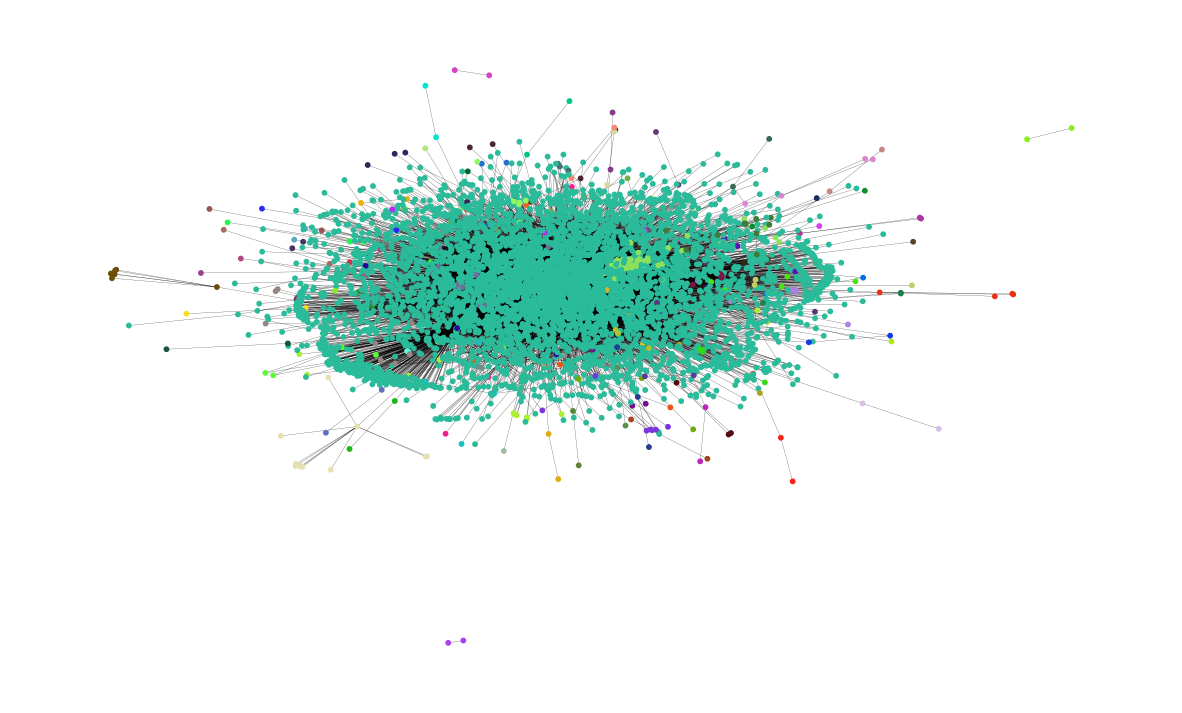

In [56]:
node_colors = [colors[node] for node in G.nodes()]

plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    G,
    pos=pos,
    node_size=10,
    with_labels=False,
    width=0.15,
    node_color=node_colors  # use the list, not the dictionary
)
plt.show()

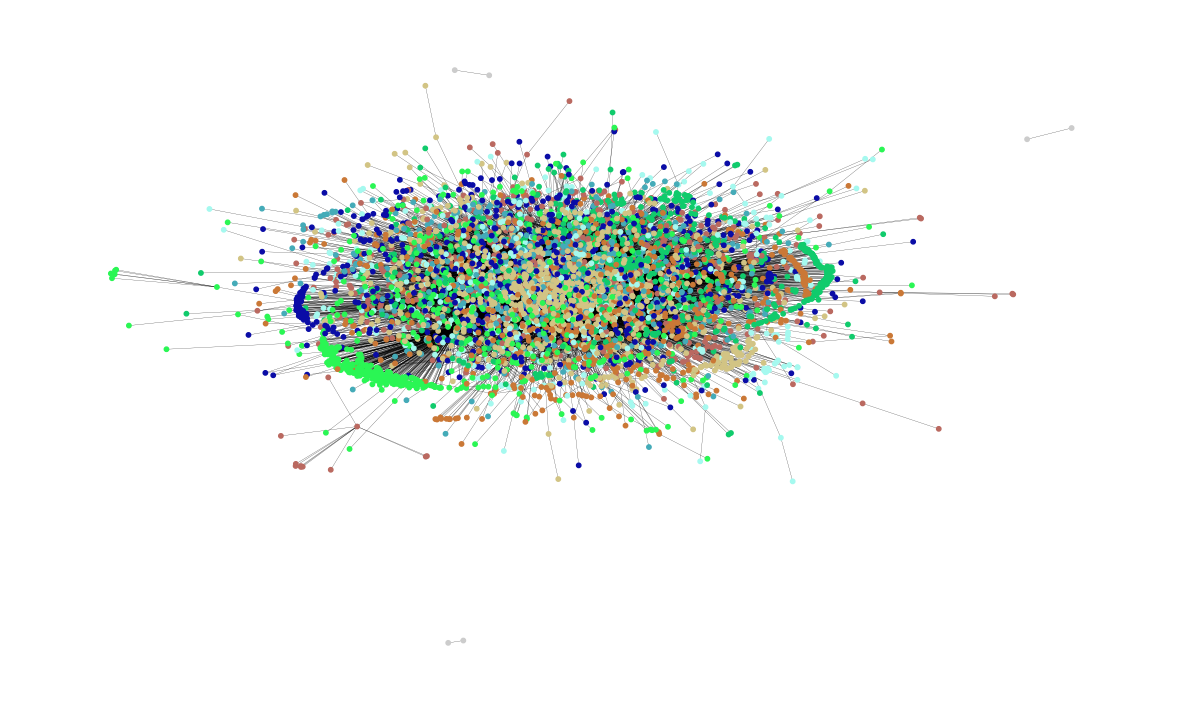

In [61]:
from networkx.algorithms.community import asyn_fluidc
from networkx.algorithms.components import connected_components
from random import randint

# Get the largest connected component
largest_cc_nodes = max(connected_components(G), key=len)
G_largest = G.subgraph(largest_cc_nodes).copy()

# Create a color mapping dictionary for the largest component
colors = {}

# Apply the community detection
for com in asyn_fluidc(G_largest, k=8, seed=0):
    color = "#%06X" % randint(0, 0xFFFFFF)
    for node in com:
        colors[node] = color

# Create node_colors list for all nodes in G
node_colors = [colors.get(node, "#CCCCCC") for node in G.nodes()]  # grey for unassigned (outside largest_cc)

# Plot
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    G, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=node_colors
)
plt.show()